In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import cell2location

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text for PDFs

Global seed set to 0
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/conda/envs/scrna/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
results_folder = './results/'

# create paths and names to results folders for reference regression and cell2location models
run_name = f'{results_folder}/cell2location_map'

In [3]:
adata_file = f"{run_name}/sp.h5ad"
adata_vis = sc.read_h5ad(adata_file)

In [4]:
adata_vis

AnnData object with n_obs × n_vars = 27912 × 10533
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'donor_id', 'region', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'feature_types', 'genome', 'SYMBOL', 'mt', 'n_cells_by_counts-6800STDY12499406', 'mean_counts-6800STDY12499406', 'log1p_mean_counts-6800STDY12499406', 'pct_dropout_by_counts-6800STDY12499406', 'total_counts-6800STDY12499406', 'log1p_total_counts-6800STDY12499406', 'n_cells_by_counts-6800STDY12499407', 'mean_counts-6800STDY12499407', 'log1p_mean_counts-6800STDY12499407', 'pct_dropout_by_counts-6800STDY12499407', 'total_counts-6800STDY12499407', 'log1p_total_counts-6800STDY12499407', 'n_cells_by_counts-6800STDY12499408', 'mean_counts-6800STDY12499408', 'log1p_mean_counts-6800STDY12499408', 'pc

In [5]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present',
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

/home/conda/envs/scrna/lib/python3.9/site-packages/pandas/core/frame.py:3641: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]


当前Anndata对象中包括了不止一张切片的数据

In [6]:
adata_vis.obs[["sample", "donor_id"]].value_counts()

sample            donor_id
6800STDY12499406  PD43824     3352
6800STDY12499508  PD47465     2831
6800STDY12499509  PD47465     2811
6800STDY12499502  PD45814     2700
6800STDY12499504  PD45815     2670
6800STDY12499503  PD45814     2661
6800STDY12499505  PD45815     2580
6800STDY12499507  PD45816     2145
6800STDY12499409  PD47512     2085
6800STDY12499411  PD47171     2048
6800STDY12499506  PD45816     2029
dtype: int64

In [12]:
list(adata_vis.obs.columns)

['in_tissue',
 'array_row',
 'array_col',
 'sample',
 'n_genes_by_counts',
 'log1p_n_genes_by_counts',
 'total_counts',
 'log1p_total_counts',
 'pct_counts_in_top_50_genes',
 'pct_counts_in_top_100_genes',
 'pct_counts_in_top_200_genes',
 'pct_counts_in_top_500_genes',
 'mt_frac',
 'donor_id',
 'region',
 '_indices',
 '_scvi_batch',
 '_scvi_labels',
 'ACKR+_EC',
 'Activated KRT+ NK',
 'Activated NK',
 'Activated_B-AREG',
 'Activated_B-RHOB',
 'CCL5+_EC',
 'CD',
 'CD4+T_Act-CCL5',
 'CD4+T_Act-CH25H',
 'CD4+T_Act-CXCR4',
 'CD4+T_Act-NR4A1',
 'CD4+T_EM',
 'CD4+T_INF-response',
 'CD4+T_Naïve/CM',
 'CD4+Treg',
 'CD8+T_Act-XCL1/2',
 'CD8+T_Cycling-G1/S',
 'CD8+T_Cycling-G2/M',
 'CD8+T_EFF.1',
 'CD8+T_EFF.2',
 'CD8+T_EM',
 'CD8+T_EMRA',
 'CD8+T_EX-CCL4L2',
 'CD8+T_EX-IL10',
 'CD8+T_Naïve/CM',
 'CD8+T_RM-CXCL13',
 'CD8+T_preEX-CXCR4',
 'CD8+T_preEX-PMCH',
 'CD principal cell',
 'CDH19+ Fibro',
 'CNN1+ Fibro',
 'CRHBP+_EC',
 'CRYAB+ Epi',
 'CYGB+ Fibro',
 'Classical Mono.1',
 'Classical Mono.2'

## Figure 7F

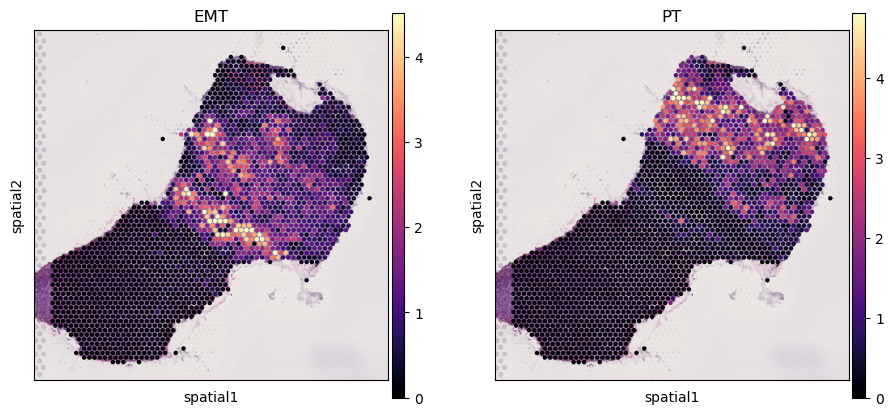

In [13]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, '6800STDY12499411')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['EMT', 'PT'],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

## Figure S5D

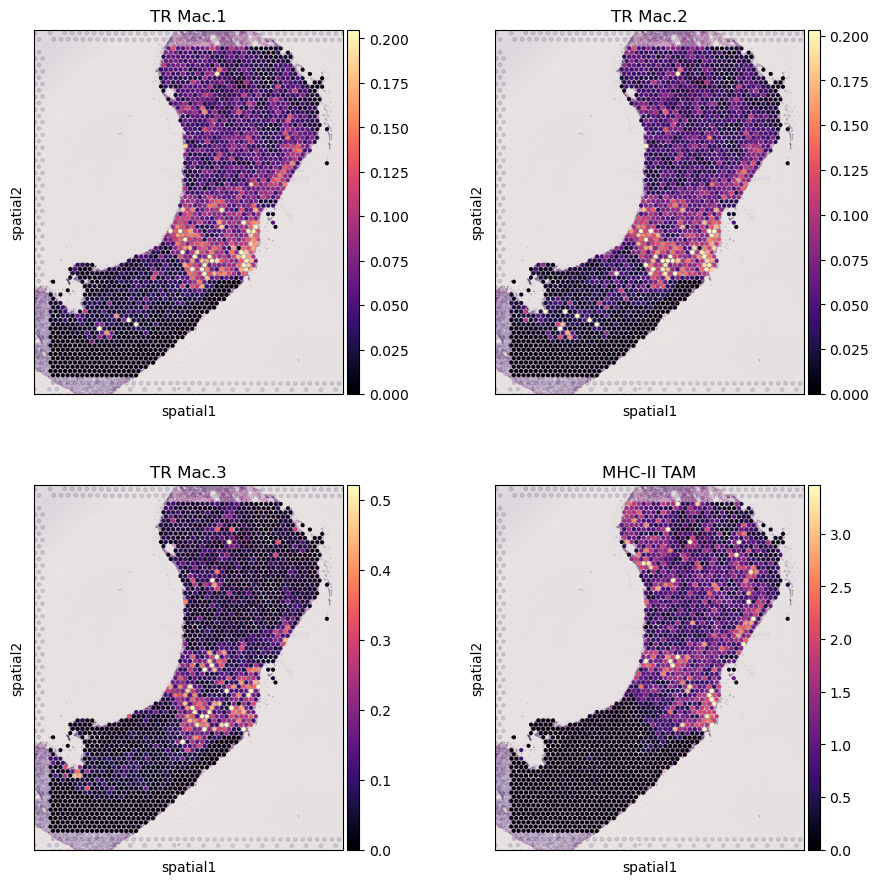

In [14]:
# select one slide
from cell2location.utils import select_slide
slide = select_slide(adata_vis, '6800STDY12499506')

# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['TR Mac.1', 'TR Mac.2', 'TR Mac.3', 'MHC-II TAM'],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

## Figure 7B

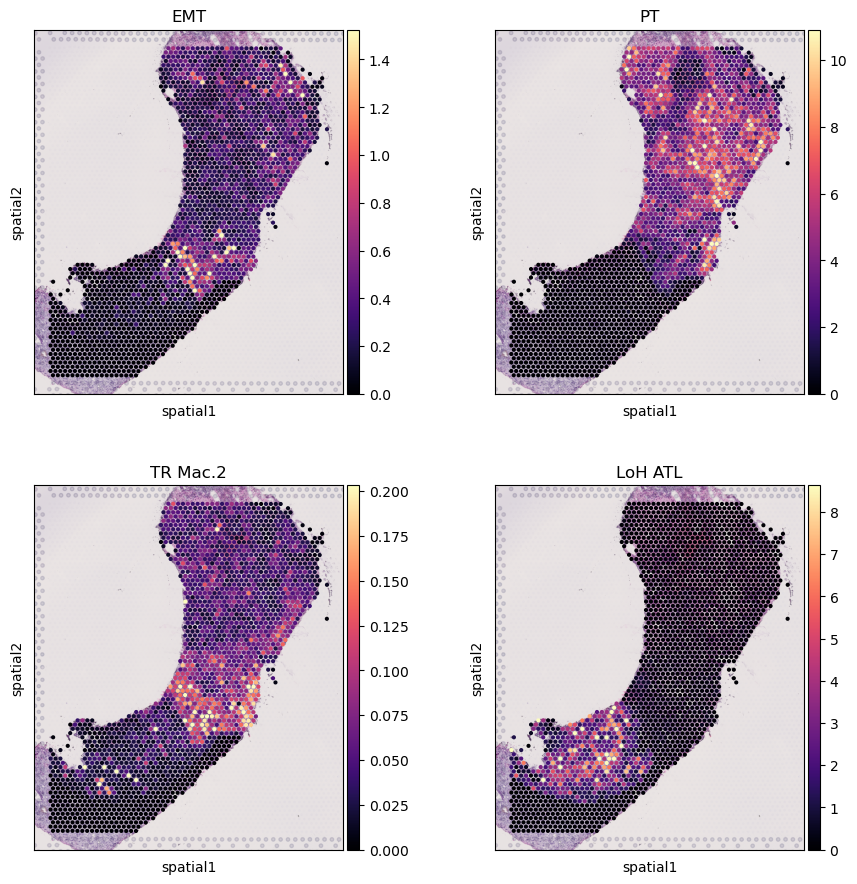

In [15]:
# plot in spatial coordinates
with mpl.rc_context({'axes.facecolor':  'black',
                     'figure.figsize': [4.5, 5]}):

    sc.pl.spatial(slide, cmap='magma',
                  # show first 8 cell types
                  color=['EMT', 'PT', 'TR Mac.2', 'LoH ATL'],
                  ncols=2, size=1.3,
                  img_key='hires',
                  # limit color scale at 99.2% quantile of cell abundance
                  vmin=0, vmax='p99.2'
                 )

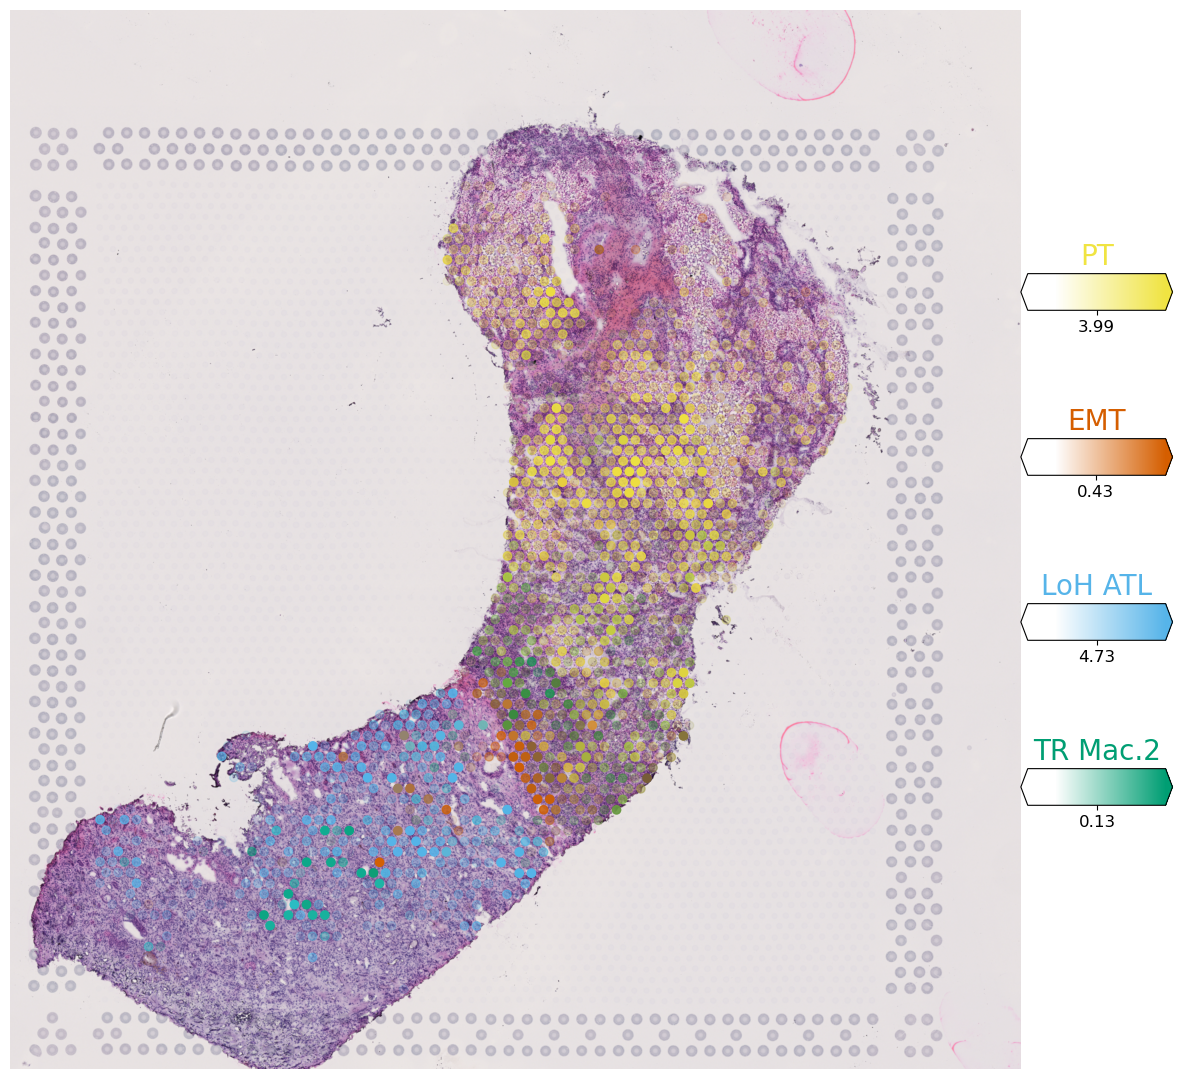

In [28]:
# Now we use cell2location plotter that allows showing multiple cell types in one panel
from cell2location.plt import plot_spatial

# select up to 6 clusters
clust_labels = ['PT', 'EMT', 'LoH ATL', 'TR Mac.2']
clust_col = ['' + str(i) for i in clust_labels] # in case column names differ from labels

# slide = select_slide(adata_vis, '6800STDY12499507')

with mpl.rc_context({'figure.figsize': (15, 15)}):
    fig = plot_spatial(
        adata=slide,
        # labels to show on a plot
        color=clust_col, labels=clust_labels,
        show_img=True,
        # 'fast' (white background) or 'dark_background'
        style='fast',
        # limit color scale at 99.2% quantile of cell abundance
        max_color_quantile=0.992,
        # size of locations (adjust depending on figure size)
        circle_diameter=6,
        colorbar_position='right'
    )
fig
# plt.savefig('figure_cell2location.pdf')